In [1]:
# Import modules
import numpy as np
import torch.nn as nn
import torch

from typing import NamedTuple, Optional
import matplotlib.pyplot as plt
from skimage.draw import line, polygon_perimeter

import typing as t
from tqdm import tqdm
import torch.nn.functional as F
from shapely.geometry import Polygon

In [2]:
# Creating data types for saving images and labels
class Poly(NamedTuple):
    points: np.ndarray
    label: np.array

class PolyImage(NamedTuple):
    image: np.ndarray
    label: np.ndarray

In [3]:
# A truncated normal distribution
def _clipped_normal(mean, var, clip_low, clip_high, size=1) -> np.ndarray:
    return np.clip(np.random.normal(mean, var, size=size), clip_low, clip_high)

# The function that generate an image with a parallelogram in it
def synthesize_data(
    has_poly: bool = None,
    noise_level: float = 0.2,
    n_lines: int = 8,
    image_size: int = 200,
    shape: str = 'parallelogram',
) -> PolyImage:

    if has_poly is None:
        has_poly = np.random.choice([True, False], p=(0.8, 0.2))

    image = _clipped_normal(0.0, noise_level, 0, 1, size=(image_size, image_size))

    def noisy_draw(x, y):
        valid = (x >= 0) & (x < image_size) & (y >= 0) & (y < image_size)
        image[x[valid], y[valid]] = _clipped_normal(0.25, noise_level, 0, 1, size=np.sum(valid))

    # poly (or no-poly)
    if has_poly:
        points, label = _polygon(
            _pos(image_size), _yaw(), _side_len(), _width_stretch(), _height_stretch(), _roundness(), shape,
        )
        noisy_draw(*polygon_perimeter(points[:, 0], points[:, 1]))
    else:
        label = np.full(5, np.nan)

    # Adding some random lines to the image
    for _ in range(n_lines):
        noisy_draw(
            *line(*np.random.randint(-image_size // 2, image_size + image_size // 2, size=4))
        )

    return PolyImage(image.T, label)


def _corners(pos_x: float, pos_y: float, yaw: float, width: float, height: float) -> np.ndarray:
    points = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]]).astype(np.float64)
    points *= np.array([width, height]) / 2
    points = _rotate(points, yaw)
    points += np.array([pos_x, pos_y])
    return points


def _polygon(
    pos: np.asarray,
    yaw: float,
    side_len: float,
    x_stretch: float,
    y_stretch: float,
    roundness: float,
    shape: str,
) -> Poly:

    # rhombus (centered at origin, side length 1)
    if shape == 'rhombus':
      points = np.array(
      [
          [1., 0.],
          [0, 1.],
          [-1., 0],
          [0, -1.],
      ])

    # Parallelogram (centered at origin, side length 1)
    elif shape == 'parallelogram':
      y_rotation = _yaw()
      x_rotation = _yaw()

      points = np.array(
      [
          _rotate(np.array([1., 0.]), x_rotation),
          _rotate(np.array([0, 1.]), y_rotation),
          _rotate(np.array([-1., 0]), x_rotation),
          _rotate(np.array([0, -1.]), y_rotation),
      ])

    # Star (centered at origin, side length 1) with given roundness
    elif shape == 'star':

      points = np.array(
      [
          [1., 0.],
          [roundness, roundness],
          [0, 1.],
          [-roundness, roundness],
          [-1., 0],
          [-roundness, -roundness],
          [0, -1.],
          [roundness, -roundness],
      ])

    # stretch, rotate, translate
    x_and_y_stretch = (side_len) * np.array([x_stretch, y_stretch])
    points *= x_and_y_stretch / 2
    points = _rotate(points, yaw)
    points += pos

    return Poly(points, np.asarray([*pos, yaw, *(x_and_y_stretch)]))

def _pos(s: float) -> np.ndarray:
    return np.random.randint(40, s - 40, size=2)

def _yaw() -> float:
    return np.random.uniform(0, 2 * np.pi)

def _side_len() -> int:
    return np.random.randint(70, 90)

def _width_stretch() -> float:
    return np.clip(np.random.normal(0.7, 0.4 / 3), 0.6, 0.8)

def _height_stretch() -> float:
    return np.clip(np.random.normal(1.3, 0.4 / 3), 1.10, 1.3)

def _roundness() -> float:
    return np.clip(np.random.normal(0.25, 0.2 / 3), 0.10, 0.40)

def _rotate(points: np.ndarray, theta: float) -> np.ndarray:
    return points @ np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


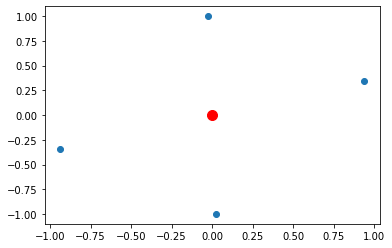

In [4]:
# Create 4 points of a Parallelogram
y_rotation = _yaw()
x_rotation = _yaw()
np.random.seed(0)
points = np.array(
[
    _rotate(np.array([1., 0.]), x_rotation),
    _rotate(np.array([0, 1.]), y_rotation),
    _rotate(np.array([-1., 0]), x_rotation),
    _rotate(np.array([0, -1.]), y_rotation),
])

fig, ax = plt.subplots()
ax.scatter(*points.T)
ax.scatter(*[0, 0], s=100, color='r')
plt.show()


yaw 3.448296944257913
pos [84 87]
side_len 82
x_stretch 0.8
y_stretch 1.3
(4, 2)
(2,)


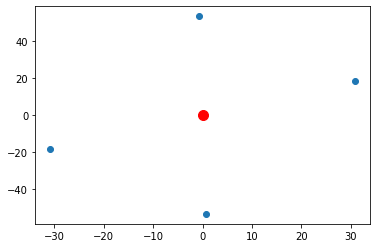

In [5]:
# Stretch 
np.random.seed(0)
side_len = _side_len()
np.random.seed(0)
x_stretch = _width_stretch()
np.random.seed(0)
y_stretch = _height_stretch()
np.random.seed(0)
yaw = _yaw()
print('yaw', yaw)
image_size = 200
np.random.seed(0)
pos = _pos(image_size)

print('pos', pos)

print('side_len', side_len)
print('x_stretch', x_stretch)
print('y_stretch', y_stretch)
np.random.seed(0)
points = np.array(
[
    _rotate(np.array([1., 0.]), x_rotation),
    _rotate(np.array([0, 1.]), y_rotation),
    _rotate(np.array([-1., 0]), x_rotation),
    _rotate(np.array([0, -1.]), y_rotation),
])

print(points.shape)
x_and_y_stretch = (side_len) * np.array([x_stretch, y_stretch])
print(x_and_y_stretch.shape)
# stretching by half of x_stretch and y_stretch
points *= x_and_y_stretch / 2

fig, ax = plt.subplots()
ax.scatter(*points.T)
ax.scatter(*[0, 0], s=100, color='r')
plt.show()

The rotation in degree is 198 degree from the x-axis (clockwise).
yaw 3.448296944257913


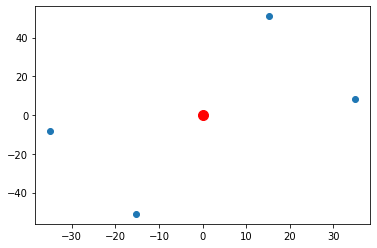

In [6]:
# Rotate
print(f'The rotation in degree is {round(360*yaw/(2*np.pi))} degree from the x-axis (clockwise).')
np.random.seed(0)
yaw = _yaw()
print('yaw', yaw)
points = _rotate(points, yaw)

fig, ax = plt.subplots()
ax.scatter(*points.T)
ax.scatter(*[0, 0], s=100, color='r')
plt.show()

Translation to a new center at [84 87].


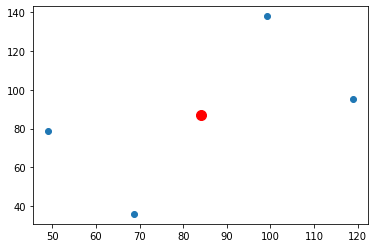

In [7]:
# Translation
np.random.seed(0)
pos = _pos(image_size)
print(f'Translation to a new center at {pos}.')
points += pos

fig, ax = plt.subplots()
ax.scatter(*points.T)
ax.scatter(*pos, s=100, color='r')
plt.show()

In [8]:
# The full process
np.random.seed(0)
side_len = _side_len()
np.random.seed(0)
x_stretch = _width_stretch()
np.random.seed(0)
y_stretch = _height_stretch()
np.random.seed(0)
yaw = _yaw()
print('yaw', yaw)
image_size = 200
np.random.seed(0)
pos = _pos(image_size)
np.random.seed(0)
roundness = _roundness()

print(pos, yaw, side_len, x_stretch, y_stretch, roundness)
_polygon(pos, yaw, side_len, x_stretch, y_stretch, roundness, 'rhombus')


yaw 3.448296944257913
[84 87] 3.448296944257913 82 0.8 1.3 0.3676034897311776


Poly(points=array([[ 52.73065199,  96.90292256],
       [ 67.90775084,  36.18730949],
       [115.26934801,  77.09707744],
       [100.09224916, 137.81269051]]), label=array([ 84.        ,  87.        ,   3.44829694,  65.6       ,
       106.6       ]))

yaw 0.9686337061529999
[115  67] 0.9686337061529999 81 0.7630647775319972 1.3 0.2815323887659986


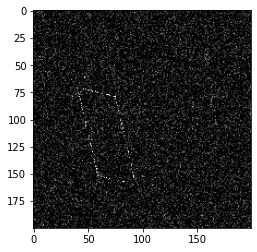

In [9]:
# Creating an image with a random Parallelogram
seed = 12
np.random.seed(seed)
side_len = _side_len()
np.random.seed(seed)
x_stretch = _width_stretch()
np.random.seed(seed)
y_stretch = _height_stretch()
np.random.seed(seed)
yaw = _yaw()
print('yaw', yaw)
image_size = 200
np.random.seed(seed)
pos = _pos(image_size)
np.random.seed(seed)
roundness = _roundness()

print(pos, yaw, side_len, x_stretch, y_stretch, roundness)
_polygon(pos, yaw, side_len, x_stretch, y_stretch, roundness, 'parallelogram')

points, label = _polygon(
    pos, yaw, side_len, x_stretch, y_stretch, roundness, 'parallelogram')

noise_level = 0.2
image = _clipped_normal(0.0, noise_level, 0, 1, size=(image_size, image_size))


def noisy_draw(x, y):
    valid = (x >= 0) & (x < image_size) & (y >= 0) & (y < image_size)
    image[x[valid], y[valid]] = _clipped_normal(0.25, 4*noise_level, 0, 1, size=np.sum(valid))
noisy_draw(*polygon_perimeter(points[:, 0], points[:, 1]))

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")
plt.show()

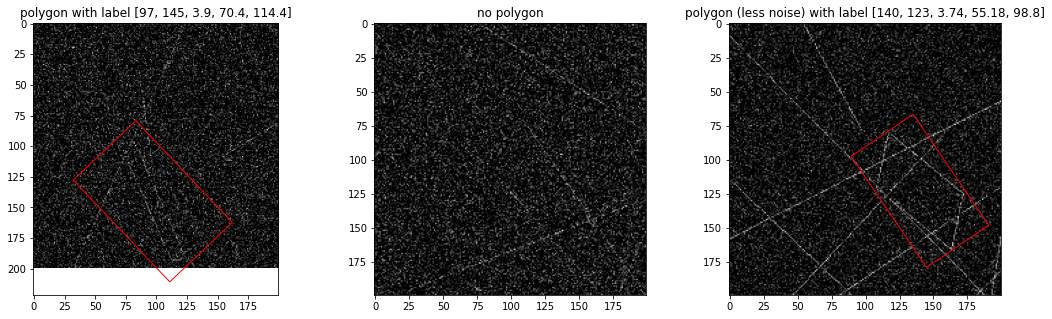

In [10]:
# Creating 3 images with high noise and low noise with and without a Parallelogram
def plot(ax, image, label, text):
    ax.imshow(image, cmap="gray")
    ax.set_title(text)
    if label.size > 0:
        bbox = _corners(*label)
        ax.fill(bbox[:, 0], bbox[:, 1], facecolor="none", edgecolor="r")


def prettify_np(a):
    return list(map(lambda x: int(x) if x.is_integer() else round(x, 2), a.tolist()))

if __name__ == "__main__":
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    shape = 'parallelogram'
    # shape = 'star'
    # shape = 'rhombus'

    image, label = synthesize_data(has_poly=True, shape=shape)
    plot(ax[0], image, label, f"polygon with label {prettify_np(label)}")

    image, label = synthesize_data(has_poly=False, shape=shape)
    plot(ax[1], image, label, "no polygon")

    image, label = synthesize_data(has_poly=True, noise_level=0.1, shape=shape)
    plot(ax[2], image, label, f"polygon (less noise) with label {prettify_np(label)}")
    fig.savefig("example.png")